# Day3宿題
### 前処理
* ガスの種類を二値で判別（E10=1,SP98=0）
* 欠損値の削除
* 型の変換

### それぞれの説明変数と目的変数の相関関係を視覚的に確かめる
* 相関係数をヒートマップにして可視化

### 線形回帰モデルの評価
* 一度、改良を加えずにMAEを計算してみる
 * データに制限を加えず、交差バリエーション法を用いてMAEを計算してみる
 * 訓練誤差,汎化誤差をホールドアウト法を用いて考える
 
* 異常値をなくし、より一般的なモデルを作成する
 * データに制限を加える
 * 交差バリエーション法を用いてMAEを計算してみる
 * 訓練誤差,汎化誤差をホールドアウト法を用いて考える
 
 * 改良を加える前の予測精度からどう変化したかを検証する

### オーバーフィッティング対処方法の実践

* 上で作成したアルゴリズムに
  * 標準化手法を適用する
  * L1正則化手法を適用する（Lasso）…できてない
  * L2正則化手法を適用する（Ridge）…できてない
  * 交差バリエーション法を用いてMAEを計算してみる･･･できてない
  * 訓練誤差,汎化誤差をホールドアウト法を用いて考える

### モデルの精度を向上させるために切り口を変えた説明変数を検討

### L1で不必要な説明変数を探す
 * 特徴選択（埋め込み法：LASSO）
 * 係数を棒グラフで表示
 * 説明変数を削除してMAEを計算してみる
 
### 決定木を用いる

### ランダムフォレストを用いる

### ニューラルネットワークを用いる･･･できてない

## ライブラリインポート

In [230]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns #特徴量選択のため
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

## データの読み込みと変換

In [231]:
#データの読み込み
#小数点がカンマで表記されているため、decimalパラメータを付与
df_fuel = pd.read_csv("./car-consume/measurements.csv",decimal=',')
#df_fuel = pd.read_excel("./car-consume/measurements2.xlsx")

# データを確認
display(df_fuel.head())
df_fuel.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [232]:
df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [233]:
#欠損値が多い項目は除外
df_fuel = df_fuel.drop(['specials'], axis=1)
df_fuel = df_fuel.drop(['refill liters'], axis=1)
df_fuel = df_fuel.drop(['refill gas'], axis=1)

#欠損値０埋め
df_fuel = df_fuel.fillna(0)

#変数gas_typeを数値で表現する
def distinctGasType(x):
    if x == "E10":
        return 0
    else:
        return 1

df_fuel["gas_type_num"] = df_fuel["gas_type"].apply(lambda x: distinctGasType(x))
df_fuel = df_fuel.drop(['gas_type'], axis=1)

df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
gas_type_num    388 non-null int64
dtypes: float64(3), int64(6)
memory usage: 27.4 KB


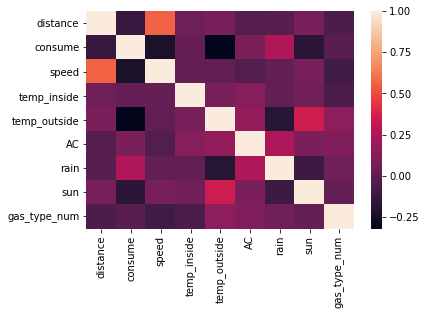

In [234]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_fuel.corr())
plt.show()

## 線形回帰

In [235]:
# 係数を求める
y = df_fuel["consume"].values
X = df_fuel[["distance","speed","temp_inside","temp_outside","AC","sun","rain","gas_type_num"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 値を予測
y_pred = regr.predict(X)

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

MAE = 0.616


## 誤差検証：ホールドアウト法

In [236]:
x = df_fuel[["distance","speed","temp_inside","temp_outside","AC","sun","rain","gas_type_num"]].values
y = df_fuel["consume"].values

X = x.reshape(-1,8) # scikit-learnに入力するために整形

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [237]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差MAE = %s"%round(mae,3) )

訓練誤差MAE = 0.617


In [238]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差MAE = %s"%round(mae,3) )

汎化誤差MAE = 0.658


## 誤差検証：交差検証（クロスバリデーション）法

In [239]:
X = x.reshape(-1,8) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.658

Fold 2
MAE = 0.629

Fold 3
MAE = 0.747

Fold 4
MAE = 0.605

Fold 5
MAE = 0.514

Cross Validation MAE = 0.631


## 標準化

(array([243.,  51.,   7.,   2.,   3.,   0.,   2.,   1.,   0.,   1.]),
 array([-0.87919898,  0.12456091,  1.1283208 ,  2.13208069,  3.13584058,
         4.13960047,  5.14336036,  6.14712025,  7.15088014,  8.15464003,
         9.15839992]),
 <a list of 10 Patch objects>)

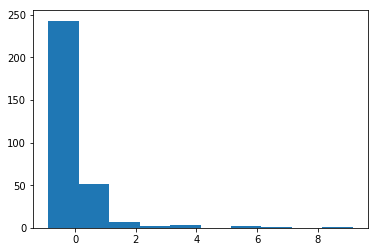

In [240]:
# 標準化後の評価のためにホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

#データの標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）

(array([66.,  8.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-0.84569245,  0.17912869,  1.20394982,  2.22877096,  3.2535921 ,
         4.27841324,  5.30323437,  6.32805551,  7.35287665,  8.37769779,
         9.40251892]),
 <a list of 10 Patch objects>)

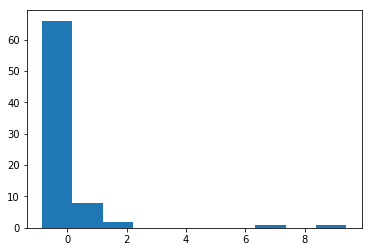

In [241]:
X_test_stand = stdsc.transform(X_test)
plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

## 標準化後の誤差検証：ホールドアウト法

In [242]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train_stand, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train_stand)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差MAE = %s"%round(mae,3) )

訓練誤差MAE = 0.617


In [243]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test_stand)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差MAE = %s"%round(mae,3) )

汎化誤差MAE = 0.658


## 異常値をなくしてみる

In [244]:
# 図を見た限りで、consume=7,11の2点が異常値としちゃう
conclusion =[]

# 異常値がないデータを作成する
fuel_test = df_fuel.copy()
fuel_final =  df_fuel.copy()
fuel_limit = fuel_test[((fuel_test.sun==0)&(fuel_test.consume<7))|(fuel_test.sun==1)].copy()
#fuel_limit = fuel_test.copy()

# 交差バリエーションを用いる
var_graph = []
var_data = fuel_limit.copy()
var_dataX = var_data[["distance","speed","temp_inside","temp_outside","AC","sun","rain","gas_type_num"]]
var_datay = var_data[["consume"]]
x = var_dataX.values
y = var_datay.values
X = x.reshape(-1,8)
n_split =10
cross_valid_mae = 0
cross_valid_mae_train = 0
split_num = 1
split_num_train = 1

# 交差バリエーションを用いる
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
   #学習用データ,テスト用データ
    X_train, y_train = X[train_idx], y[train_idx] 
    X_test, y_test = X[test_idx], y[test_idx]
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X_train, y_train)

    # 訓練誤差を計算する
    y_pred_train = regr.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    cross_valid_mae_train += mae_train 
    split_num_train += 1
   
    # 汎化誤差を計算する
    y_pred_test = regr.predict(X_test)    
    mae = mean_absolute_error(y_test, y_pred_test)
    cross_valid_mae += mae 
    split_num += 1

# MAEの平均値を最終的な汎訓練誤差値とする
final_mae_train = cross_valid_mae_train / n_split
var_graph.append(final_mae_train)
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
var_graph.append(final_mae)
# lastデータの下準備
fuel_finalX = fuel_final[["distance","speed","temp_inside","temp_outside","AC","sun","rain","gas_type_num"]].copy()
fuel_finaly = fuel_final[["consume"]].copy()
x_last = fuel_finalX.values
y_last = fuel_finaly.values
X_last = x_last.reshape(-1,8)
y_pred_last = regr.predict(X_last)
mae_final = mean_absolute_error(y_last, y_pred_last)
var_graph.append(mae_final)

# 1*3行列に変換
var_graph = np.reshape(var_graph,(1,3)) 
conclusion.append(var_graph)
var_graph = pd.DataFrame(var_graph ,index=["MAE"] ,columns = ["(var)訓練誤差","(var)汎化誤差","(var)最終的な誤差"])
display(var_graph) 

,(var)訓練誤差,(var)汎化誤差,(var)最終的な誤差
MAE,0.706371,0.810891,0.860565


## 特徴選択（埋め込み法：LASSO）

In [245]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [246]:
train_label = df_fuel["consume"]
train_data = df_fuel.drop("consume", axis=1)

y = train_label.values
X = train_data.values
#X = df_fuel[["distance","speed","temp_inside","temp_outside","sun","rain","AC"]].values

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [247]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False,  True,  True,  True,  True,  True,  True, False])

In [248]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
#X.columns[removed_idx]
train_data.columns[removed_idx]

Index(['distance', 'gas_type_num'], dtype='object')

In [249]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.        , 0.01422504, 0.002421  , 0.03843498, 0.24540444,
       0.46766299, 0.07553356, 0.        ])

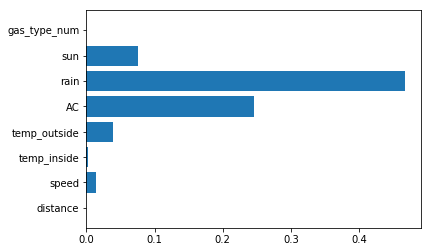

In [250]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

## 上の結果をふまえ'distance', 'gas_type_num'は説明変数から省く

## 決定木

In [251]:
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz
X_train = df_fuel[["speed","temp_inside","temp_outside","AC","sun","rain"]].values
y_train = df_fuel["consume"].values
#clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = DecisionTreeRegressor(max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))
#print(clf.predict(X_test)) #予測したい場合

score= 0.6759409354851267


[0.53187413 0.06620856 0.33941008 0.00242752 0.00812944 0.05195027]


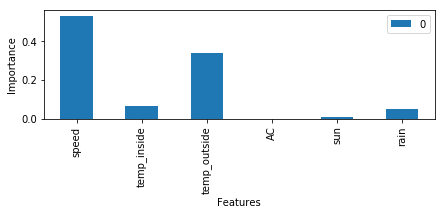

In [252]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=["speed","temp_inside","temp_outside","AC","sun","rain"]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

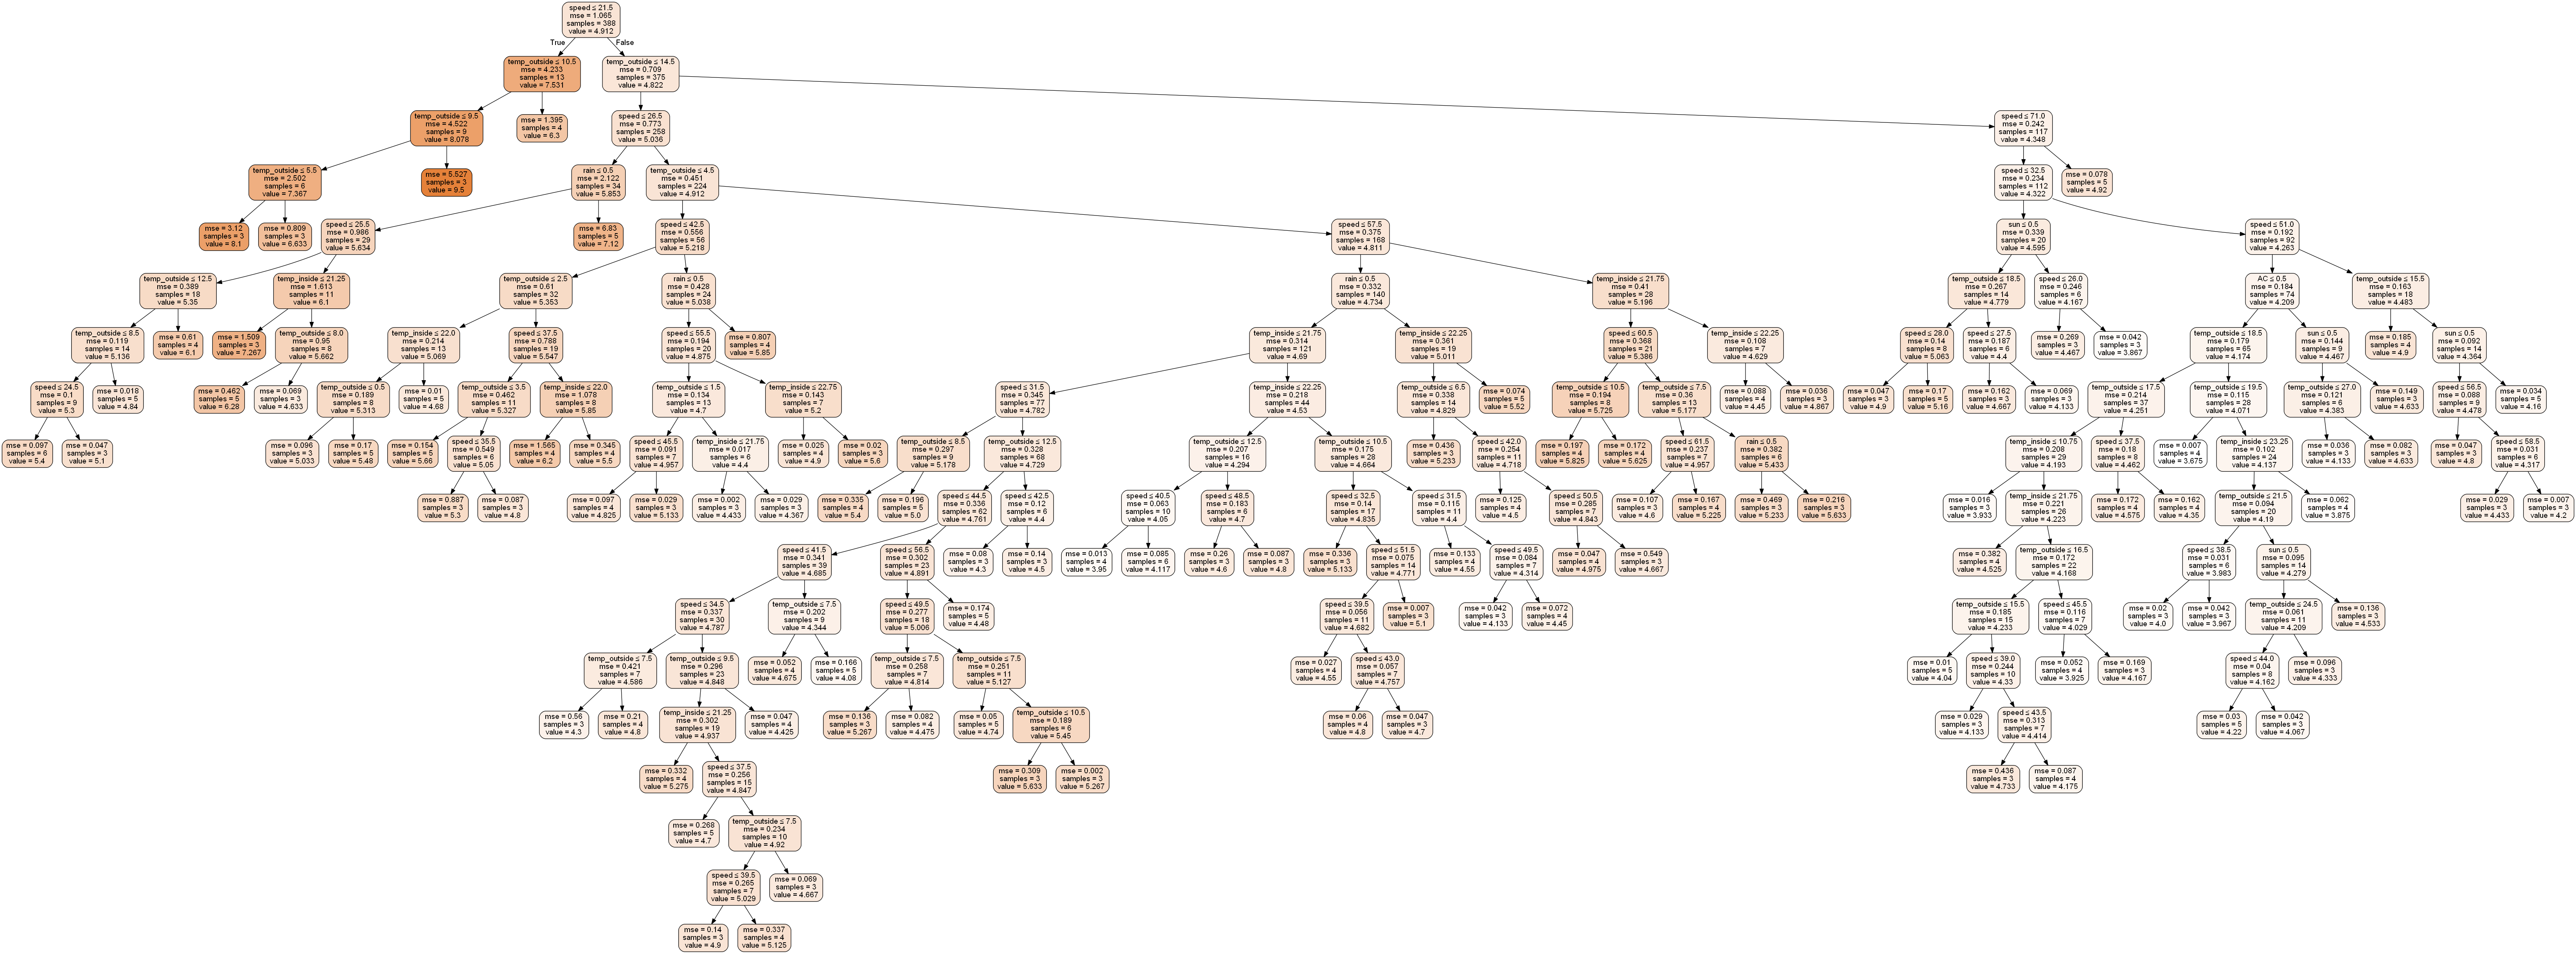

In [253]:
# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=["speed","temp_inside","temp_outside","AC","sun","rain"],  
                     class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

## ランダムフォレスト

score= 0.6333679738184941
訓練誤差MAE = 0.498
汎化誤差MAE = 0.614
[0.75129282 0.00209445 0.         0.22272069 0.         0.00607774
 0.         0.0178143 ]


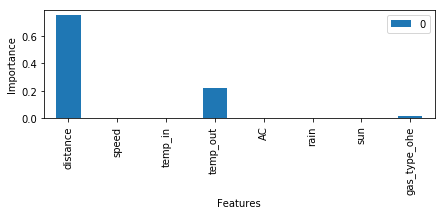

MAE = 0.614


In [255]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

#clf = RandomForestRegressor(n_estimators=10, criterion="mae", max_depth=12, min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf = RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差MAE = %s"%round(mae,3) )

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差MAE = %s"%round(mae,3) )

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=['distance','speed','temp_in','temp_out','AC','rain','sun', 'gas_type_ohe']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

### ニューラルネットワーク